# Домашнее задание 2. StarGAN

## Этап 1. Установка зависимостей, инициализация и загрузка данных

В этом разделе мы работаем с датасетом CelebA, содержащим изображения лиц с набором атрибутов. Целью задания является генерация новых изображений лиц с заданными характеристиками.

In [1]:
import torch
from lpips import LPIPS
from torchvision import transforms
from munch import Munch
from tqdm.auto import trange
import matplotlib.pyplot as plt
import numpy as np
from celeba_loader import CelebADataset

device_str = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device(device_str)
print(f"Working with {device!r}")

Working with device(type='mps')


In [2]:
args = Munch()
args.img_size = 256  # Размер изображений после преобразования
args.batch_size = 4

# Создание последовательности преобразований для подготовки изображений
transform=transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])

# Загрузка датасета CelebA с применением указанных преобразований
dataset = CelebADataset(
    root_dir='data',
    attrs_subset=['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young'],
    transform=transform
)

num_workers = 0
pin_memory = False

# Создание DataLoader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=args.batch_size,
    num_workers=num_workers,
    pin_memory=pin_memory,
    shuffle=True
)

In [3]:
args.num_domains = len(dataset.header)
print(args.num_domains)
print(dataset.header)

5
['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']


### Визуализация датасета

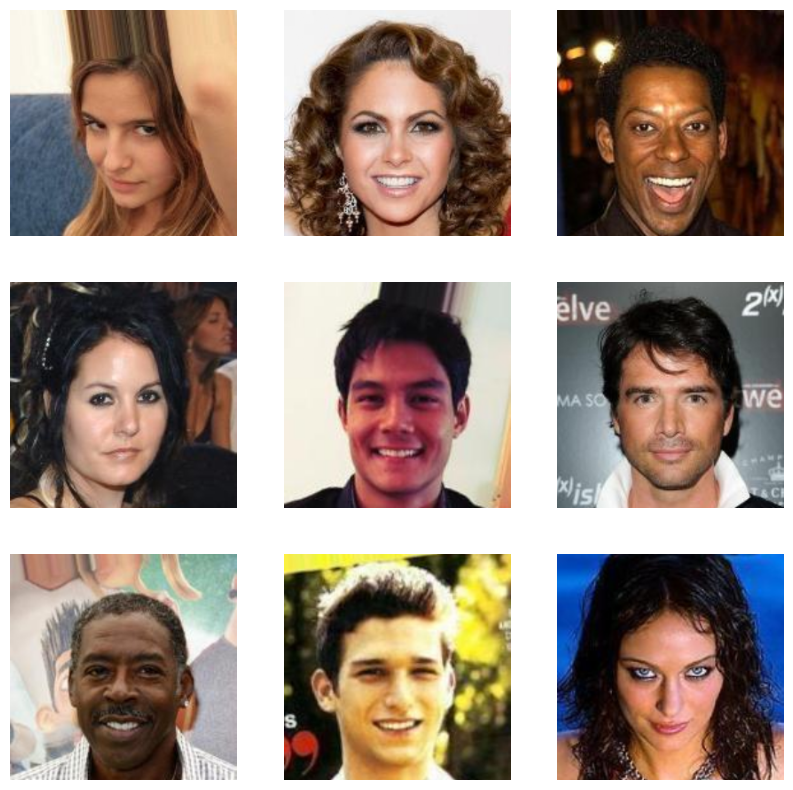

In [4]:
# Визуализация случайно выбранных изображений из датасета

_, axes = plt.subplots(ncols=3, nrows=3, figsize=(10, 10))
for i, img_idx in enumerate(np.random.choice(range(len(dataset)), 9)):

    img, target = dataset[img_idx]
    img = (img - img.min()) / (img.max() - img.min())
    axes[i // 3][i % 3].imshow(img.detach().cpu().numpy().transpose(1, 2, 0))
    #axes[i // 3][i % 3].set_title(target['attributes'])
    axes[i // 3][i % 3].axis('off')
#print(dataset.header)

## Этап 2. Инициализация и обучение модели

В этом этапе необходимо реализовать и обучить модель StarGAN для генерации лиц с заданными атрибутами.

Вы можете выбрать одну из следующих моделей:
- [StarGANv1](https://arxiv.org/pdf/1711.09020.pdf) (**до 4 баллов**)
- [StarGANv2](https://arxiv.org/abs/1912.01865) (**до 7 баллов**)

### Инициализация

Ниже приведён шаблон для определения основных компонентов модели. Реализуйте их по своему усмотрению.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

args.conv_dim = 64
args.repeat_num = 6


class ResidualBlock(nn.Module):
    """Residual Block with instance normalization."""
    def __init__(self, dim_in, dim_out):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True))

    def forward(self, x):
        return x + self.main(x)


class Generator(nn.Module):
    """Generator network."""
    def __init__(self, conv_dim=64, c_dim=5, repeat_num=6):
        super(Generator, self).__init__()

        layers = []
        layers.append(nn.Conv2d(3+c_dim, conv_dim, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.InstanceNorm2d(conv_dim, affine=True, track_running_stats=True))
        layers.append(nn.ReLU(inplace=True))

        # Down-sampling layers.
        curr_dim = conv_dim
        for i in range(2):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim*2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim * 2

        # Bottleneck layers.
        for i in range(repeat_num):
            layers.append(ResidualBlock(dim_in=curr_dim, dim_out=curr_dim))

        # Up-sampling layers.
        for i in range(2):
            layers.append(nn.ConvTranspose2d(curr_dim, curr_dim//2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim//2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2

        layers.append(nn.Conv2d(curr_dim, 3, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.Tanh())
        self.main = nn.Sequential(*layers)

    def forward(self, x, c):
        # Replicate spatially and concatenate domain information.
        # Note that this type of label conditioning does not work at all if we use reflection padding in Conv2d.
        # This is because instance normalization ignores the shifting (or bias) effect.
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        return self.main(x)


class Discriminator(nn.Module):
    """Discriminator network with PatchGAN."""
    def __init__(self, image_size=128, conv_dim=64, c_dim=5, repeat_num=6):
        super(Discriminator, self).__init__()
        layers = []
        layers.append(nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.01))

        curr_dim = conv_dim
        for i in range(1, repeat_num):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1))
            layers.append(nn.LeakyReLU(0.01))
            curr_dim = curr_dim * 2

        kernel_size = int(image_size / np.power(2, repeat_num))
        self.main = nn.Sequential(*layers)
        self.conv1 = nn.Conv2d(curr_dim, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(curr_dim, c_dim, kernel_size=kernel_size, bias=False)

    def forward(self, x):
        h = self.main(x)
        out_src = self.conv1(h)
        out_cls = self.conv2(h)
        return out_src, out_cls.view(out_cls.size(0), out_cls.size(1))

nets = Munch()
nets.generator = Generator(conv_dim=args.conv_dim, c_dim=args.num_domains, repeat_num=args.repeat_num).to(device)
nets.discriminator = Discriminator(image_size=args.img_size, conv_dim=args.conv_dim, c_dim=args.num_domains, repeat_num=args.repeat_num).to(device)

### Обучение

In [6]:
import os
args.weights_dir = 'out/weights'
args.sample_dir = 'out/samples'


os.makedirs(args.weights_dir, exist_ok=True)
os.makedirs(args.sample_dir, exist_ok=True)

args.g_lr = 0.0001
args.d_lr = 0.0001
args.beta1, args.beta2 = 0.5, 0.999

args.lambda_cls = 1 # weight for domain classification loss
args.lambda_rec = 10 # weight for reconstruction loss
args.lambda_gp = 10 # weight for gradient penalty

args.n_critic = 5 # D updates per G update

args.log_step = 10
args.sample_step = 1000
args.weights_save_step = 1000
args.lr_update_step = 1000

optims = Munch()
optims.generator = torch.optim.Adam(nets.generator.parameters(), lr=args.g_lr, betas=(args.beta1, args.beta2))
optims.discriminator = torch.optim.Adam(nets.discriminator.parameters(), lr=args.d_lr, betas=(args.beta1, args.beta2))

In [ ]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=args.batch_size,
    num_workers=num_workers,
    pin_memory=pin_memory,
    shuffle=True
)

from torchvision.utils import save_image
from torchvision.utils import make_grid
import torch
import torch.nn.functional as F
import numpy as np
import os
import time
import datetime

args.begin_iters = 0
args.num_iters = 100000


x_fixed, c_org = next(iter(dataloader))
x_fixed = x_fixed.to(device)
c_org = c_org['attributes']

hair_color_indices = []
for i, attr_name in enumerate(dataset.header):
    if attr_name in ['Black_Hair', 'Blond_Hair', 'Brown_Hair']:
        hair_color_indices.append(i)

c_trg_list = []
for i in range(args.num_domains):
    c_trg = c_org.clone()
    if i in hair_color_indices:  # Set one hair color to 1 and the rest to 0.
        c_trg[:, i] = 1
        for j in hair_color_indices:
            if j != i:
                c_trg[:, j] = 0
    else:
        c_trg[:, i] = (c_trg[:, i] == 0)  # Reverse attribute value.

    c_trg_list.append(c_trg.to(device))
c_fixed_list = c_trg_list
# !!!!

#x_fixed = (x_fixed - x_fixed.min()) / (x_fixed.max() - x_fixed.min())

# Start training.
print('Start training...')
start_time = time.time()
for i in range(args.begin_iters, args.num_iters):
    x_real, label_org = next(iter(dataloader))
    label_org = label_org['attributes'].float()

    # Generate target domain labels randomly.
    rand_idx = torch.randperm(label_org.size(0))
    label_trg = label_org[rand_idx]

    c_org = label_org.clone()
    c_trg = label_trg.clone()


    x_real = x_real.to(device)           # Input images.
    c_org = c_org.to(device)             # Original domain labels.
    c_trg = c_trg.to(device)             # Target domain labels.
    label_org = label_org.to(device)     # Labels for computing classification loss.
    label_trg = label_trg.to(device)     # Labels for computing classification loss.

    # !!! Train discriminator !!!

    # Compute loss with real images.
    out_src, out_cls = nets.discriminator(x_real)
    d_loss_real = - torch.mean(out_src)
    d_loss_cls = F.binary_cross_entropy_with_logits(out_cls, label_org, size_average=False) / out_cls.size(0)

    # Compute loss with fake images.
    x_fake = nets.generator(x_real, c_trg)
    out_src, out_cls = nets.discriminator(x_fake.detach())
    d_loss_fake = torch.mean(out_src)

    # Compute loss for gradient penalty.
    alpha = torch.rand(x_real.size(0), 1, 1, 1).to(device)
    x_hat = (alpha * x_real.data + (1 - alpha) * x_fake.data).requires_grad_(True)
    out_src, _ = nets.discriminator(x_hat)
    dydx = torch.autograd.grad(outputs=out_src,
                                inputs=x_hat,
                                grad_outputs=torch.ones(out_src.size()).to(device),
                                retain_graph=True,
                                create_graph=True,
                                only_inputs=True)[0]

    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
    d_loss_gp = torch.mean((dydx_l2norm-1)**2)

    # Backward and optimize.
    d_loss = d_loss_real + d_loss_fake + args.lambda_cls * d_loss_cls + args.lambda_gp * d_loss_gp

    optims.generator.zero_grad()
    optims.discriminator.zero_grad()
    d_loss.backward()
    optims.discriminator.step()

    # Logging.
    loss = {}
    loss['D/loss_real'] = d_loss_real.item()
    loss['D/loss_fake'] = d_loss_fake.item()
    loss['D/loss_cls'] = d_loss_cls.item()
    loss['D/loss_gp'] = d_loss_gp.item()

    # !!! Train generator !!!

    if (i+1) % args.n_critic == 0:
        # Original-to-target domain.
        x_fake = nets.generator(x_real, c_trg)
        out_src, out_cls = nets.discriminator(x_fake)
        g_loss_fake = - torch.mean(out_src)
        g_loss_cls = F.binary_cross_entropy_with_logits(out_cls, label_trg, size_average=False) / out_cls.size(0)

        # Target-to-original domain.
        x_reconst = nets.generator(x_fake, c_org)
        g_loss_rec = torch.mean(torch.abs(x_real - x_reconst))

        # Backward and optimize.
        g_loss = g_loss_fake + args.lambda_rec * g_loss_rec + args.lambda_cls * g_loss_cls
        optims.generator.zero_grad()
        optims.discriminator.zero_grad()
        g_loss.backward()
        optims.generator.step()

        # Logging.
        loss['G/loss_fake'] = g_loss_fake.item()
        loss['G/loss_rec'] = g_loss_rec.item()
        loss['G/loss_cls'] = g_loss_cls.item()

    ### !!! logging !!!
    if (i+1) % args.log_step == 0:
        et = time.time() - start_time
        et = str(datetime.timedelta(seconds=et))[:-7]
        log = "Elapsed [{}], Iteration [{}/{}]".format(et, i+1, args.num_iters)
        for tag, value in loss.items():
            log += ", {}: {:.4f}".format(tag, value)
        print(log)

    if (i + 1) % args.sample_step == 0:
        with torch.no_grad():
            x_fake_list = [x_fixed]

            for c_fixed in c_fixed_list:
                x_fake = nets.generator(x_fixed, c_fixed)
                x_fake_list.append(((x_fake + 1) / 2).clamp_(0, 1))
            x_concat = torch.cat(x_fake_list, dim=3)

            sample_path = os.path.join(args.sample_dir, '{}-images.jpg'.format(i+1))
            save_image(x_concat, sample_path, nrow=1, padding=0)
            print('Saved real and fake images into {}...'.format(sample_path))

    if (i + 1) % args.weights_save_step == 0:
        G_path = os.path.join(args.weights_dir, '{}-generator.pth'.format(i+1))
        D_path = os.path.join(args.weights_dir, '{}-discriminator.pth'.format(i+1))
        torch.save(nets.generator, G_path)
        torch.save(nets.discriminator, D_path)
        print('Saved model checkpoints into {}...'.format(args.weights_dir))


In [7]:
nets.generator = torch.load("trained_generator.pth", weights_only=False, map_location=device)
nets.discriminator = torch.load("trained_discriminator.pth", weights_only=False, map_location=device)

### Оценка модели

Для оценки качества сгенерированных изображений используется метрика LPIPS.

In [8]:
lpips = LPIPS()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/Users/mgorodov/hse/4/gen_models/hw2/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mgorodov/hse/4/gen_models/hw2/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/mgorodov/hse/4/gen_models/hw2/.venv/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


In [9]:
test_iters = 100  # Количество итераций для тестирования модели
values = []

for i in trange(test_iters):
    x_real, _ = next(iter(dataloader))
    x_real = x_real.to(device)
    y_trg = torch.randint(0, 2, (x_real.size(0), args.num_domains), device=device)

    # Генерация изображения с использованием вашей модели
    x_fake = nets.generator(x_real, y_trg)

    # Вычисление LPIPS между сгенерированным и реальным изображением
    lpips_vals = lpips(x_fake.cpu(), x_real.cpu()).squeeze()
    values.extend(lpips_vals.tolist())

print("Среднее значение LPIPS:", np.mean(values))
assert np.mean(values) < 1.3

  0%|          | 0/100 [00:00<?, ?it/s]

Среднее значение LPIPS: 0.2391306528635323


### Вывод результатов оценки

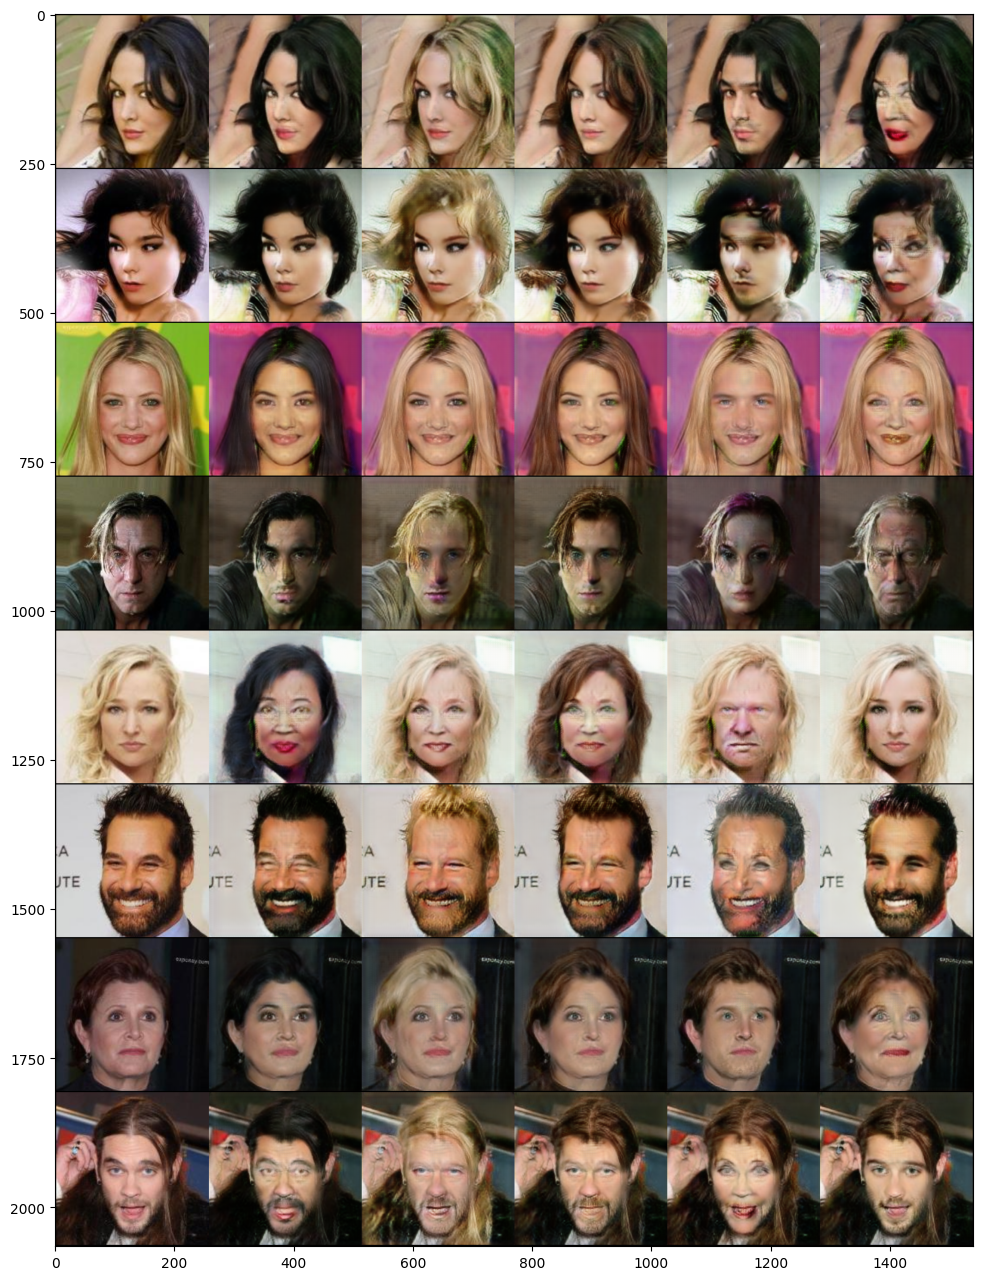

In [12]:
from torchvision.utils import make_grid, save_image
plt.figure(figsize=(16, 16))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

x_fixed, c_org = next(iter(dataloader))
x_fixed = x_fixed.to(device)
c_org = c_org['attributes']

hair_color_indices = []
for i, attr_name in enumerate(dataset.header):
    if attr_name in ['Black_Hair', 'Blond_Hair', 'Brown_Hair']:
        hair_color_indices.append(i)

c_trg_list = []
for i in range(args.num_domains):
    c_trg = c_org.clone()
    if i in hair_color_indices:  # Set one hair color to 1 and the rest to 0.
        c_trg[:, i] = 1
        for j in hair_color_indices:
            if j != i:
                c_trg[:, j] = 0
    else:
        c_trg[:, i] = (c_trg[:, i] == 0)  # Reverse attribute value.

    c_trg_list.append(c_trg.to(device))
c_fixed_list = c_trg_list

with torch.no_grad():
    x_fake_list = [((x_fixed + 1) / 2).clamp(0, 1)]

    for c_fixed in c_fixed_list:
        x_fake = nets.generator(x_fixed, c_fixed)
        x_fake_list.append(((x_fake + 1) / 2).clamp_(0, 1))
    x_concat = torch.cat(x_fake_list, dim=3)
    plt.imshow(make_grid(x_concat, nrow=1).permute(1, 2, 0).detach().cpu().numpy())
plt.show()

['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']


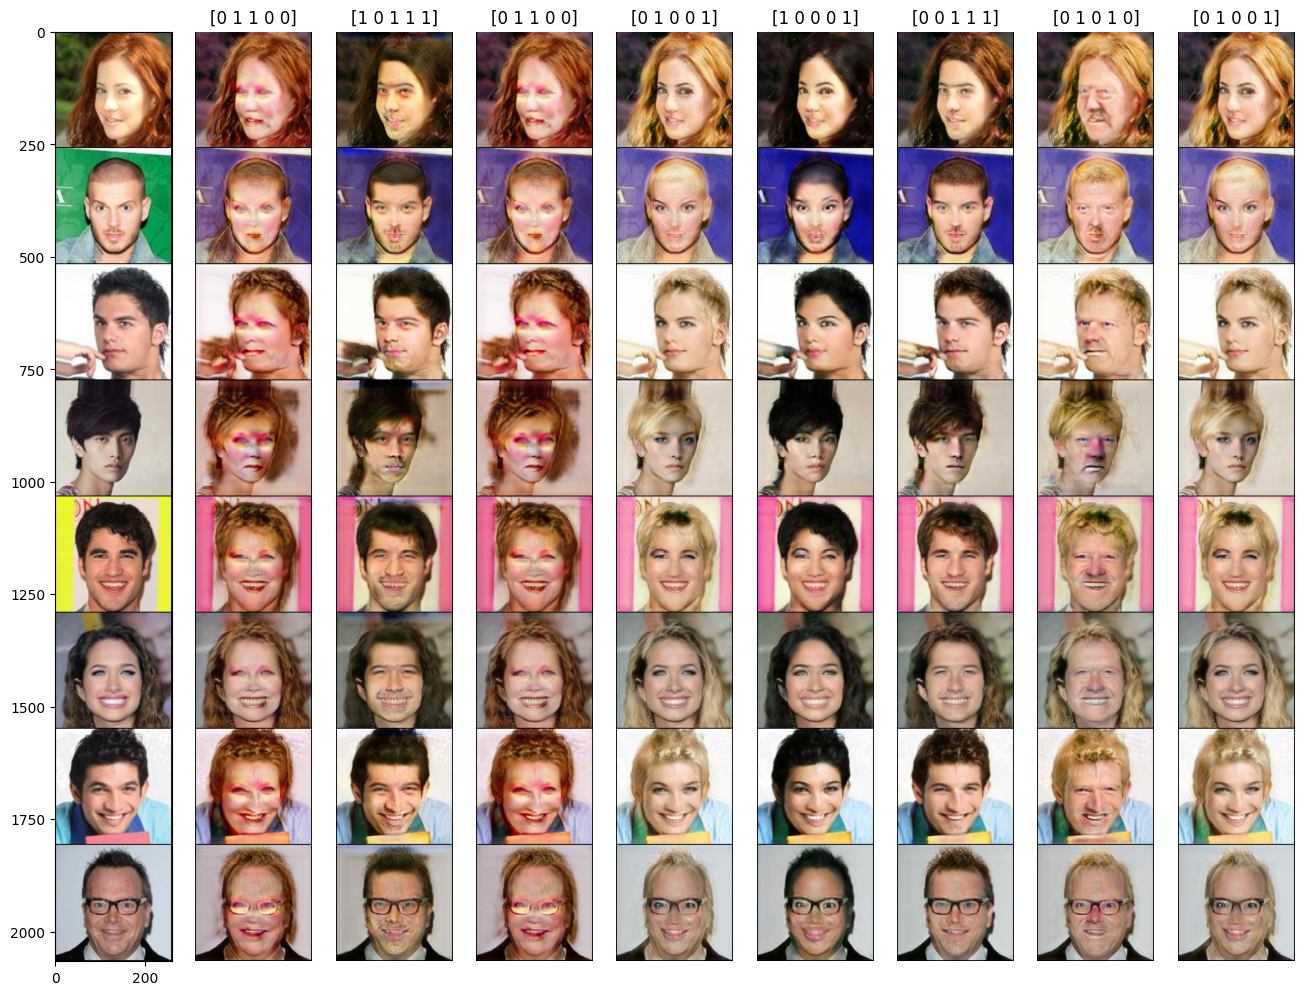

In [18]:
plt.figure(figsize=(16, 16))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
x_fixed, _ = next(iter(dataloader))
x_fixed = x_fixed.to(device)

print(dataset.header)
plt.subplot(1, 9, 1)
plt.imshow(make_grid(((x_fixed + 1) / 2).clamp(0, 1), nrow=1).permute(1, 2, 0).detach().cpu().numpy())
with torch.no_grad():

    for i in range(8):
        plt.subplot(1, 9, i+2)
        random_column = np.random.randint(0, 2, (8, 1))
        # Дублируем столбец 5 раз вдоль оси 1, получая массив (8, 5)
        tensor = np.repeat(random_column, 5, axis=1)
        y_trg_row = torch.randint(0, 2, (1, args.num_domains), device=device)
        y_trg = y_trg_row.repeat(x_fixed.size(0), 1)

        x_fake = nets.generator(x_fixed, y_trg)
        plt.imshow(make_grid(((x_fake + 1) / 2).clamp_(0, 1), nrow=1).permute(1, 2, 0).detach().cpu().numpy())
        plt.title(y_trg_row.cpu().numpy()[0])
        plt.axis('off')
plt.show()

## Этап 3. Дополнительный анализ

В данном разделе рекомендуется провести дополнительные эксперименты и анализ:
- **Анализ латентного пространства**. *(2 балла)*
- **Текстовое ревью решения**: опишите, какие изменения можно внести для улучшения модели, и обоснуйте их. *(1 балл)*

Форма латентных признаков: torch.Size([8, 256, 64, 64])
Используемое значение perplexity: 7


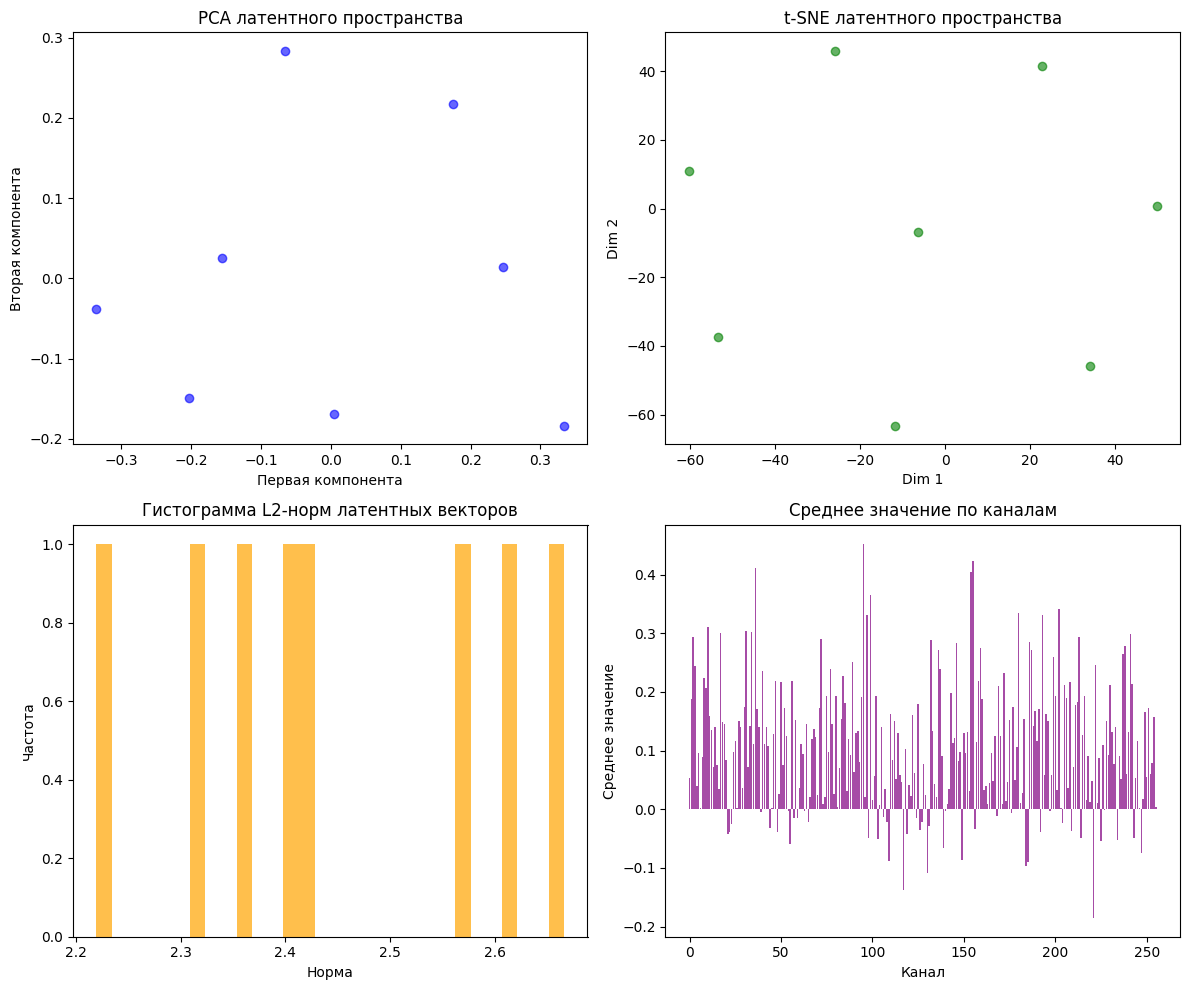

In [29]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

latent_features = None

def hook(module, input, output):
    global latent_features
    latent_features = output.detach().cpu()

# Регистрируем hook на каком-нибудь residual блоке генератора
hook_handle = nets.generator.main[14].register_forward_hook(hook)


image, _ = next(iter(dataloader))
c = torch.randint(0, 2, (image.size(0), args.num_domains), device=device)
with torch.no_grad():
    generated = nets.generator(image.to(device), c.to(device))

hook_handle.remove()

print("Форма латентных признаков:", latent_features.shape)
latent_vectors = latent_features.mean(dim=[2, 3]).numpy()  # [batch_size, channels]

n_samples = latent_vectors.shape[0]
perplexity_val = min(30, n_samples - 1)
print(f"Используемое значение perplexity: {perplexity_val}")

plt.figure(figsize=(12, 10))

# 1. PCA: двухмерное отображение латентного пространства
pca = PCA(n_components=2)
latent_2d_pca = pca.fit_transform(latent_vectors)
plt.subplot(2, 2, 1)
plt.scatter(latent_2d_pca[:, 0], latent_2d_pca[:, 1], c='blue', alpha=0.6)
plt.title("PCA латентного пространства")
plt.xlabel("Первая компонента")
plt.ylabel("Вторая компонента")

# 2. t-SNE: альтернативное отображение латентного пространства с корректным perplexity
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_val)
latent_2d_tsne = tsne.fit_transform(latent_vectors)
plt.subplot(2, 2, 2)
plt.scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], c='green', alpha=0.6)
plt.title("t-SNE латентного пространства")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")

# 3. Гистограмма распределения L2-норм латентных векторов
latent_norms = (latent_vectors ** 2).sum(axis=1) ** 0.5
plt.subplot(2, 2, 3)
plt.hist(latent_norms, bins=30, color='orange', alpha=0.7)
plt.title("Гистограмма L2-норм латентных векторов")
plt.xlabel("Норма")
plt.ylabel("Частота")

# 4. Средние значения по каналам латентного вектора
channel_means = latent_vectors.mean(axis=0)  # [channels]
plt.subplot(2, 2, 4)
plt.bar(range(len(channel_means)), channel_means, color='purple', alpha=0.7)
plt.title("Среднее значение по каналам")
plt.xlabel("Канал")
plt.ylabel("Среднее значение")

plt.tight_layout()
plt.show()



Хотелось бы попробовать обучить модель на всех атрибутах, но это очень дорого по ресурсам

Собственно все хорошие изменения, которыми можно было бы улучшить модель были внесены в starganv2)))

